In [11]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [14, 10]

In [12]:
import numpy as np
import pandas as pd

In [13]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [15]:
engine = create_engine("sqlite:///Hawaii_Climate_Data/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [17]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

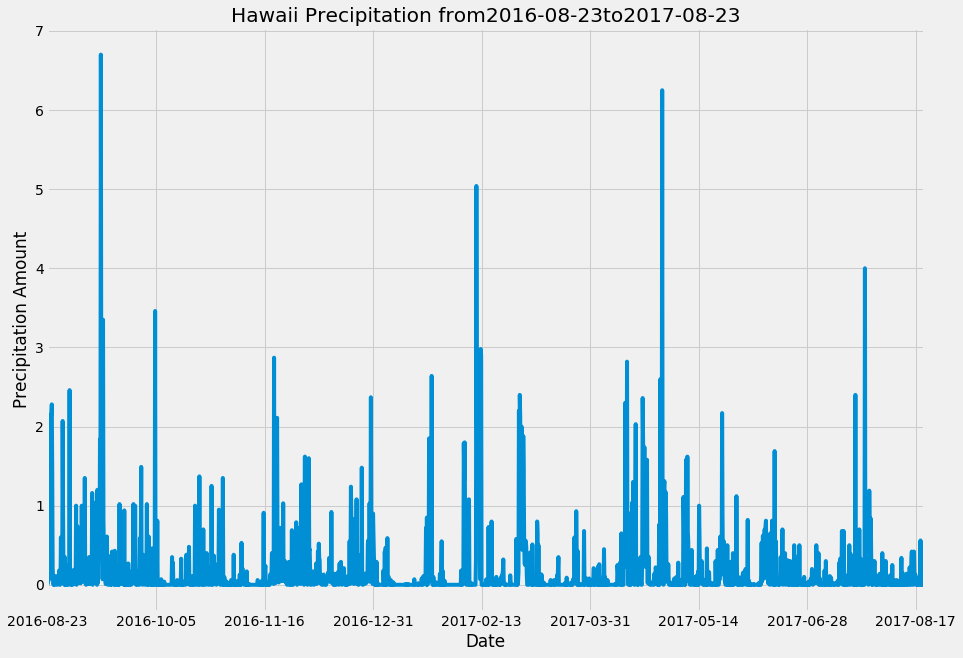

In [20]:
#Extract All Avialable Dates from Measurements Table
date_list = engine.execute('SELECT date FROM Measurement')

#Loop Thruough Dates to Find Latest Record
for date in date_list:
    last_date = date[0]
    
#Split Lastest Date Record at Dashes to Isolate Year/Month/Day
date_split = last_date.split('-')

#Subtract One from Year Index
date_split[0] = str(int(date_split[0]) - 1)

#Re-Assemble Date Value & Record as Year Prior Date
prior_date = date_split[0] + '-' + date_split[1] + '-' + date_split[2]

#Query Database to Create Pandas Data Frame of Precipitation Data for Selected Year-Long Period
precip_data = pd.read_sql('SELECT date, prcp FROM Measurement WHERE date >= (?)', engine, params = (prior_date,))

#Drop Rows with Missing Values
precip_data = precip_data.dropna()

#Set Date Values as Data Frame Index
precip_data = precip_data.set_index('date')

#Sort Data Frame by Date
precip_data = precip_data.sort_index()

#Plot Bar Chart of Precipitation History for Selected Year
precip_data.plot(legend = None)
plt.xlabel('Date')
plt.ylabel('Precipitation Amount')
plt.title('Hawaii Precipitation from' + prior_date + 'to' + last_date)
plt.show()

In [21]:
#Calculate Summary Statistics for Precipitation Data
precip_count = precip_data.count()
precip_mean = precip_data.mean()
precip_std = precip_data.std()
precip_min = precip_data.min()
precip_first = precip_data.quantile(0.25)
precip_second = precip_data.quantile(0.5)
precip_third = precip_data.quantile(0.75)
precip_max = precip_data.max()

#Create Data Frame of Precipitation Data Summary Statistics
precip_summary = pd.DataFrame({'precipitation': [precip_count[0], precip_mean[0], precip_std[0], precip_min[0],
                                                 precip_first[0], precip_second[0], precip_third[0], precip_max[0]]},
                              index = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

precip_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
#Extract Unique Weather Station IDs from Database
unique_stations = engine.execute('SELECT COUNT(DISTINCT station) FROM Station')

#Display Unique Weather Station Count
for count in unique_stations:
    print(count)

(9,)


In [29]:
#Extract Weather Station Activity from Database & Sort in Descending Order
active_stations = engine.execute('SELECT Measurement.station, Station.name, COUNT(Measurement.station) AS station_occurence FROM Measurement INNER JOIN Station ON Station.station = Measurement.station GROUP BY Measurement.station ORDER BY station_occurence DESC')

#Display List of Weather Stations from Most Active to Least Active
for occurences in active_stations:
    print(occurences)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [45]:
#Extract Maximum/Minimum/Average Temperature Data from Database for Most Active Weather Station
busiest_station = engine.execute('SELECT MAX(tobs) as max_temp, MIN(tobs) as min_temp, AVG(tobs) as avg_temp FROM Measurement WHERE station = :busiest', busiest = 'USC00519281')

#Display Maximum/Minimum/Average Temperature Data for Most Active Weather Station
for stats in busiest_station:
    print(stats)

(85.0, 54.0, 71.66378066378067)


In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
precip_data = pd.read_sql('SELECT date, tobs FROM Measurement WHERE date >= (?) AND WHERE station = (?)', engine, params = (prior_date, 'USC00519281',))

precip_data

OperationalError: (sqlite3.OperationalError) near "WHERE": syntax error
[SQL: SELECT date, tobs FROM Measurement WHERE date >= (?) AND WHERE station = (?)]
[parameters: ('2016-08-23', 'USC00519281')]
(Background on this error at: http://sqlalche.me/e/e3q8)

# Temperature Analysis

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


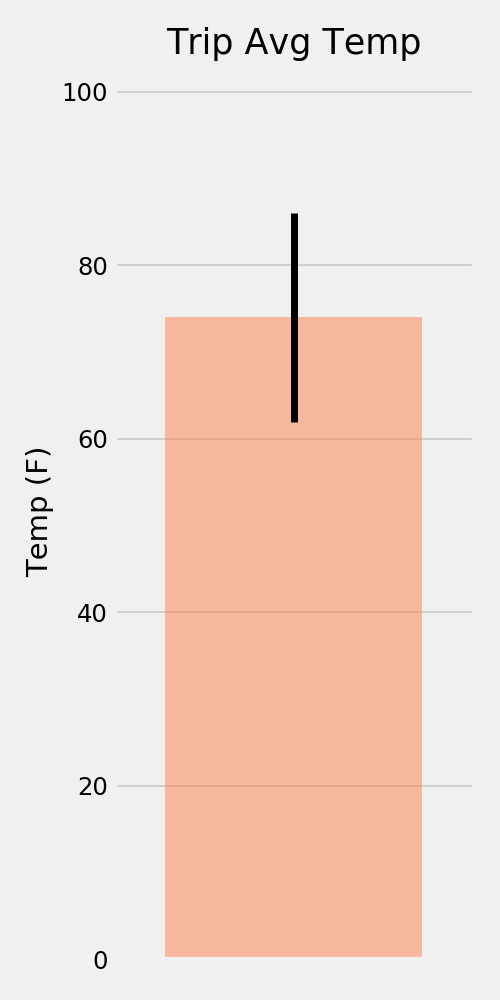

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


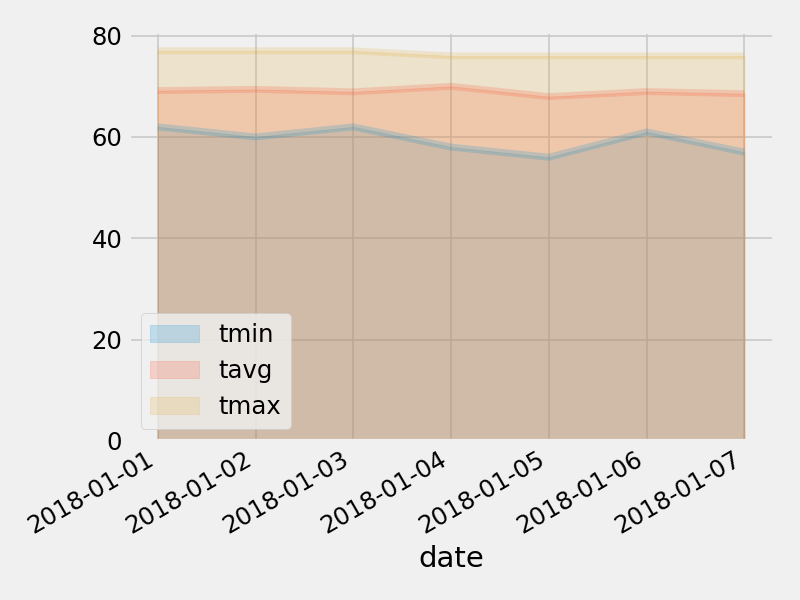

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
